In [1]:
%matplotlib inline

import pickle as pkl # fileを読み込んだり出力する
import numpy as np # 行列を扱うので
import tensorflow as tf
import matplotlib.pyplot as plt # グラフ

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# real_dim 本物 
# z_dim ノイズの次元(サイズ)
# 変数を格納するplaceholder生成
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, input_z

In [5]:
# z 100 ノイズ数 
# out_dim 784 出力数
# n_units 隠れ層 128ノード
# reuse 関数内の変数を保持するか。
# alpha Leaky ReLUの０以下での傾き

def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse): # 'generator'の時にreuseオプションを使用する
        h1 = tf.layers.dense(z, n_units, activation=None) # ＮＮ１層目
        h1 = tf.maximum(alpha * h1,h1) #Leaky ReLU # ＮＮ２層目
        
        logits = tf.layers.dense(h1, out_dim, activation=None) # 出力層（３層目）
        out = tf.tanh(logits) # tanh(ハイパボリックタンジェント) -1~1の間で分布させる
        return out

In [6]:
# x 入力値 
# out_dim 784 出力数
# n_units 隠れ層 128ノード
# reuse 関数内の変数を保持するか。
# alpha Leaky ReLUの０以下での傾き

def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse): # 'discriminator'の時にreuseオプションを使用する
        h1 = tf.layers.dense(x, n_units, activation=None) # ＮＮ１層目
        h1 = tf.maximum(alpha*h1, h1) #Leaky ReLU # ＮＮ２層目
        
        logits = tf.layers.dense(h1, 1, activation=None) # 出力層（３層目）。ネットワークの最終層なので１つに結合
        out = tf.sigmoid(logits) # sigmoid 0~1の間で分布させる　確率分布、スカラー
        
        return out, logits

In [104]:
# ハイパーパラメーターの初期化

input_size = 784 # 28*28
z_size = 80 # ベクトル
g_hidden_size = 128 # 隠れ層のノード数
d_hidden_size = 128 # 隠れ層のノード数
alpha = 0.01 # Leaky ReLU
smooth = 0 # Discriminatorの学習を円滑にするために調整。

In [105]:
# 計算グラフ初期化
tf.reset_default_graph()
# placeholder定義 phpでいうlist的な。
input_real, input_z = model_inputs(input_size, z_size)

# generator実行(data生成)
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# discriminator実行(本物)、本物データのスコアを取得
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)

# discriminator実行(偽物),generatorで生成したデータをdiscriminatorへ。学習するのでreuseをtrueにする。
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [106]:
#損失関数の定義
# reduce_mean 平均
# cross_entropy 交差エントロピー：正解に近ければ値が小さくなる、正解から離れれば値が大きくなる
# すべてに１(本物)のラベルを与える。今回は-0.1でバイアスをかけている
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)*(1 - smooth)))
# すべてに0(偽物)のラベルを与える
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels = tf.zeros_like(d_logits_real)))
# discriminatorのloss
# 第一項 本物をtrueと判定する精度
# 第二項 偽物をfalseと判定する精度
# 最終的に１に近づけばおｋ
d_loss = d_loss_real + d_loss_fake

# generatorのloss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))


In [107]:
#最適化の定義
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')] # 変数の一式をとりだす
d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # variable_scopeのやつ

# 最小化する
d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [108]:
# 100個ランダムにとってくる
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [109]:
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([1, 7, 5, 6, 9, 8, 9, 0, 3, 4, 8, 3, 2, 2, 4, 3, 3, 5, 6, 2, 1, 5,
        0, 8, 4, 5, 5, 8, 5, 1, 8, 7, 2, 6, 1, 7, 8, 9, 8, 3, 1, 3, 3, 8,
        2, 9, 5, 5, 9, 9, 4, 3, 4, 7, 1, 6, 1, 7, 3, 3, 2, 3, 3, 9, 0, 2,
        4, 3, 9, 3, 3, 4, 2, 4, 5, 3, 2, 3, 4, 3, 0, 5, 9, 4, 8, 5, 0, 3,
        6, 0, 7, 8, 7, 4, 6, 1, 8, 4, 4, 7], dtype=uint8))

In [110]:
len(batch[0]) #何個？


100

In [111]:
batch[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [112]:
batch[1][0]

1

In [113]:
#トレーニング実行

In [114]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Generator
            batch_z = np.random.uniform(-1,1,size=(batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("エポック {}/{} ".format(e+1, epochs),
        "D ロス: {:.4f} ".format(train_loss_d),
        "G ロス: {:.4f} ".format(train_loss_g))
            
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                              feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

エポック 1/100  D ロス: 0.0148  G ロス: 4.3484 
エポック 2/100  D ロス: 0.1213  G ロス: 6.0464 
エポック 3/100  D ロス: 1.0610  G ロス: 1.8175 
エポック 4/100  D ロス: 2.2965  G ロス: 1.9942 
エポック 5/100  D ロス: 1.4790  G ロス: 4.4034 
エポック 6/100  D ロス: 1.0360  G ロス: 7.4537 
エポック 7/100  D ロス: 1.7435  G ロス: 0.8870 
エポック 8/100  D ロス: 1.3718  G ロス: 1.1608 
エポック 9/100  D ロス: 3.2009  G ロス: 0.8794 
エポック 10/100  D ロス: 2.1204  G ロス: 0.8592 
エポック 11/100  D ロス: 1.1671  G ロス: 0.9606 
エポック 12/100  D ロス: 1.3112  G ロス: 1.3281 
エポック 13/100  D ロス: 0.9317  G ロス: 1.9159 
エポック 14/100  D ロス: 0.6741  G ロス: 3.6695 
エポック 15/100  D ロス: 3.4796  G ロス: 2.6066 
エポック 16/100  D ロス: 0.8416  G ロス: 4.1798 
エポック 17/100  D ロス: 0.9424  G ロス: 3.5270 
エポック 18/100  D ロス: 1.0788  G ロス: 3.7469 
エポック 19/100  D ロス: 1.1871  G ロス: 1.4531 
エポック 20/100  D ロス: 1.4521  G ロス: 2.3973 
エポック 21/100  D ロス: 0.8938  G ロス: 1.7053 
エポック 22/100  D ロス: 1.1097  G ロス: 2.1610 
エポック 23/100  D ロス: 0.7314  G ロス: 2.2038 
エポック 24/100  D ロス: 0.9107  G ロス: 2.7482 
エポック 25/100  D ロス: 1.2890

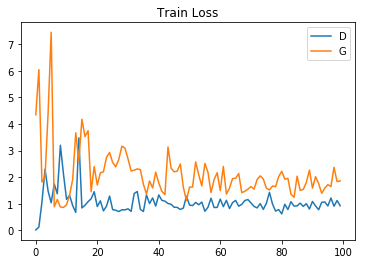

In [115]:
fig, ax=plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label='D')
plt.plot(losses.T[1],label='G')
plt.title('Train Loss')
plt.legend()

In [116]:
## 画像に変換して表示

In [117]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax,img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
                       
    return fig, axes
        

In [118]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

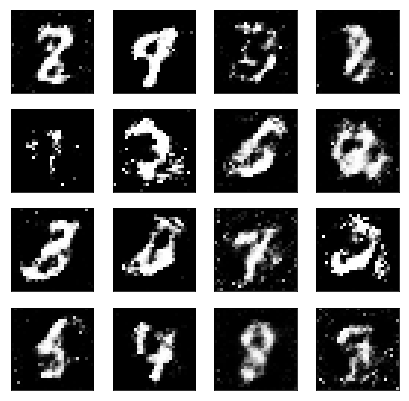

In [119]:
_ = view_samples(-1, samples)

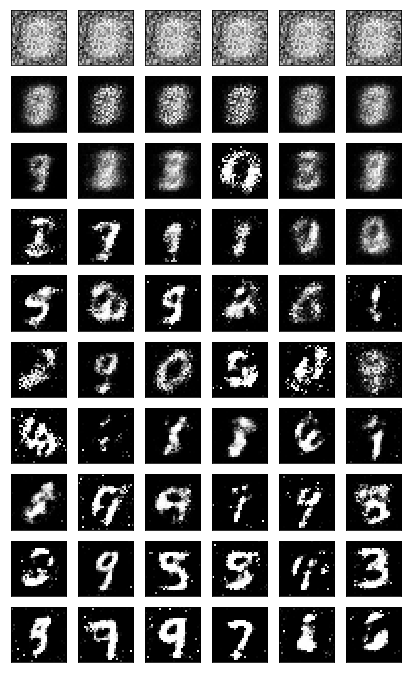

In [120]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12),nrows=rows, ncols=cols,sharex=True ,sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## チェックポイントファイルから機会に画像を生成させる

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


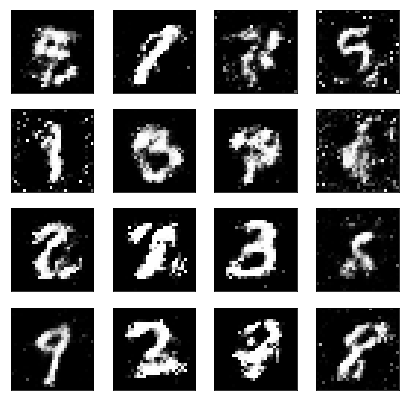

In [121]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                          feed_dict={input_z: sample_z})
    _ = view_samples(0,[gen_samples])